# Get the data

In [1]:
import numpy as np 
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
random_state=0

In [2]:
# The data is provided by the Johns Hopkins University
# https://github.com/CSSEGISandData/COVID-19
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [3]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,174,237,273,281,299,349,367,423,444,484
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,716,847,986,1171,1251,1320,1423,1468,1572,1666
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19


In [4]:
# only work with a limited amount of data
df = df[df.columns[:82]]

In [5]:
# rawData contains the values of confirmed cases in the world
firstDateIndex = df.columns.get_loc("1/22/20")
rawData = [0 for i in range(firstDateIndex, df.shape[1])]
for i in range(df.shape[1] - firstDateIndex):
    rawData[i] = sum(df.iloc[:, i+firstDateIndex])

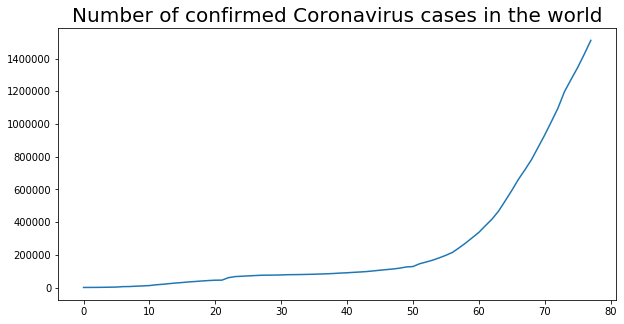

In [6]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.title('Number of confirmed Coronavirus cases in the world', size=20)
plt.plot(range(len(rawData)), rawData)
plt.show()

### The data can be split in 2 parts: 
1. The linear part made of the first 50 elements 
2. The rest of the data which is non-linear

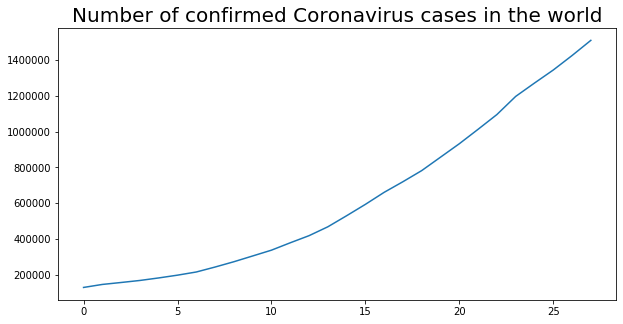

In [7]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.title('Number of confirmed Coronavirus cases in the world', size=20)
plt.plot(range(len(rawData[50:])), rawData[50:])
plt.show()

In [8]:
originalData = deepcopy(rawData)
rawData = rawData[50:]

In [9]:
numberOfDaysToForcast = 5

In [10]:
import datetime
numberOfAvailableDays = len(rawData)
numberOfDays = numberOfAvailableDays + numberOfDaysToForcast
day1 = datetime.datetime.strptime('1/22/2020', '%m/%d/%Y')
day50 = day1 + datetime.timedelta(days=50)
availableDateRange = [day50 + datetime.timedelta(days=x) for x in range(numberOfAvailableDays)]
futureDateRange = [availableDateRange[-1]  + datetime.timedelta(days=x) for x in range(1, numberOfDaysToForcast + 1)]
fullAvailableDateRange = [day1 + datetime.timedelta(days=x) for x in range(len(originalData))]
print('Dates to be predicted:')
futureDateRange

Dates to be predicted:


[datetime.datetime(2020, 4, 9, 0, 0),
 datetime.datetime(2020, 4, 10, 0, 0),
 datetime.datetime(2020, 4, 11, 0, 0),
 datetime.datetime(2020, 4, 12, 0, 0),
 datetime.datetime(2020, 4, 13, 0, 0)]

# Prepare the Dataset

In [11]:
# This is how I form my dataset from the rawData variable

# rawData = [1 2 3 4 5]:
# x=[1 2] y=3
# x=[2 3] y=4
# x=[3 4] y=5
# number of training data = 5 - 2

# rawData = [1 2 3 4 5 6]:
# x=[1 2] y=3
# x=[2 3] y=4
# x=[3 4] y=5
# x=[4 5] y=6
# number of training data = 6 - 2

In [12]:
numberOfPreviousData = 7

In [13]:
testFraction = 0.3
numberOfTrainingTestRecords = len(rawData) - numberOfPreviousData
numberOfUsableData = numberOfTrainingTestRecords - numberOfPreviousData + 2
numberOfTestData = int(np.ceil(testFraction * numberOfUsableData))

# Select Model

In [14]:
# Select a good machine learning algorithm for this dataset By picking the one that fits the data well and has the lowest error

## Baseline: Persistance model

In [15]:
y_actual = np.array(rawData[-numberOfTestData:])
y_predicted = np.array(rawData[-numberOfTestData-1:-1])
errors = np.abs(y_actual - y_predicted) / np.array(y_predicted)
baselineError = errors.mean()
print('MAE error: ', baselineError)

MAE error:  0.06643926615469971


## Machine Learning models

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [17]:
def findBestParameters(model, train_X, train_y):
    modelName = model.__class__.__name__
    parameters = {}
    if modelName == 'SVR':
        parameters = {
            'C':[1000, 100, 10, 1],
            'epsilon': [0.1, 0.01, 0.05, 0.001],
            'gamma': ['scale', 'auto']}
        
    elif modelName == 'RandomForestRegressor':
        parameters = {
            'n_estimators': [10, 50, 100, 150, 200, 400, 600]}
        
    elif modelName == 'MLPRegressor':
        parameters = {
            'hidden_layer_sizes': [(5), (10), (20), 
                        (5, 5), (10, 10), (20, 20), (30, 30),
                        (5, 5, 5), (10, 10, 10), (20, 20, 20)],
            'max_iter': [100, 500, 1000, 2000]}
    
    clf = GridSearchCV(model, param_grid=parameters, cv=5)
    clf.fit(train_X, train_y)
    #print('Best parameters for', modelName, '\n', clf.best_params_)
    
    if modelName == 'SVR':
        return SVR(C=clf.best_params_['C'], epsilon=clf.best_params_['epsilon'], gamma=clf.best_params_['gamma'])
    elif modelName == 'RandomForestRegressor':
        return RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'])
    elif modelName == 'MLPRegressor':
        return MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'], max_iter= clf.best_params_['max_iter'])
    return np.nan

## SVM, MLP, RF

### Build the datasets needed to do the recursive multi-step predictions and then train the models with them

In [18]:
# Build the dataset for training and testing
X = np.zeros((numberOfTrainingTestRecords, numberOfPreviousData))
y = np.zeros(numberOfTrainingTestRecords)
for i in range(numberOfTrainingTestRecords):
    for j in range(numberOfPreviousData):
        X[i, j] = deepcopy(rawData[i + j])
    y[i] = deepcopy(rawData[i + numberOfPreviousData])

In [19]:
# Split the dataset into train and test
X_train = X[0: -numberOfTestData, :]
y_train = y[0: -numberOfTestData]
X_test = X[-numberOfTestData:, :]
y_test = y[-numberOfTestData:]

In [20]:
# Normalize
maxValue = max(rawData)
X_train = X_train /maxValue
y_train = y_train /maxValue
X_test = X_test /maxValue
y_test = y_test /maxValue

In [21]:
def recursiveForcast(model):
    errors = np.zeros(numberOfDaysToForcast)
    dataUsedToForcast = np.concatenate([y_train[-numberOfPreviousData:], y_test]).copy()
    for f in range(len(y_test) - numberOfDaysToForcast + 1):
        movingX = deepcopy(dataUsedToForcast[f: f + numberOfPreviousData])
        for i in range(numberOfDaysToForcast):
            newForcast = model.predict(movingX.reshape(1, -1))
            observedValue = dataUsedToForcast[f + numberOfPreviousData + i]
            # define the error to be the fraction of observed value
            currentError = np.abs(newForcast - observedValue)
            errors[i] = errors[i] + currentError/newForcast
            for j in range(movingX.shape[0] - 1): # Shift
                movingX[j] = movingX[j+1]
            movingX[-1] = newForcast
    recursiveMethodError = errors / (len(y_test) - numberOfDaysToForcast + 1)
    print('MAE error for', model.__class__.__name__, recursiveMethodError)
    return recursiveMethodError

In [22]:
allModels = [SVR(), MLPRegressor(), RandomForestRegressor()]
recursiveError = []
for m in allModels:
    m = findBestParameters(m, X_train, y_train)
    m.fit(X_train, y_train)
    recursiveMethodError = recursiveForcast(m)
    if m.__class__.__name__ == 'SVR':
        recursiveError = recursiveMethodError

C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimizat

MAE error for SVR [0.03190068 0.04172162 0.04176365 0.04657749 0.05391859]


C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

MAE error for MLPRegressor [1.04590134 1.71847072 1.9225864  1.8696879  1.62124851]
MAE error for RandomForestRegressor [0.15218187 0.22406718 0.2942965  0.37223231 0.45402956]


C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Forcast using all available data 

In [23]:
# train the SVM model on all available data and then make predictions for the upcoming days

In [24]:
# Build the dataset for training and testing
X = np.zeros((numberOfTrainingTestRecords, numberOfPreviousData))
y = np.zeros(numberOfTrainingTestRecords)
for i in range(numberOfTrainingTestRecords):
    for j in range(numberOfPreviousData):
        X[i, j] = deepcopy(rawData[i + j])
    y[i] = deepcopy(rawData[i + numberOfPreviousData])

In [25]:
# Split the dataset into train and test
X_train = X.copy()
y_train = y.copy()
X_test = deepcopy(np.array(rawData[-numberOfPreviousData:]))

In [26]:
# Normalize
maxValue = max(rawData)
X_train = X_train /maxValue
y_train = y_train /maxValue
X_test = X_test /maxValue

In [27]:
def recursiveForcast(model):
    movingX = deepcopy(X_test)
    predictions = np.zeros(numberOfDaysToForcast)
    for i in range(numberOfDaysToForcast):
        newForcast = model.predict(movingX.reshape(1, -1))
        for j in range(movingX.shape[0] - 1): # Shift
            movingX[j] = movingX[j+1]
        movingX[-1] = newForcast
        predictions[i] = newForcast
    predictions = predictions * maxValue
    predictions = [int(np.round(x)) for x in predictions]
    print('Predictions:', predictions)
    return predictions

In [28]:
model = SVR()
model = findBestParameters(model, X_train, y_train)
model.fit(X_train, y_train)
recursivePredictions = recursiveForcast(model)

Predictions: [1599620, 1685137, 1768087, 1835772, 1893026]


C:\Users\Meysam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


C:\Users\Meysam\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


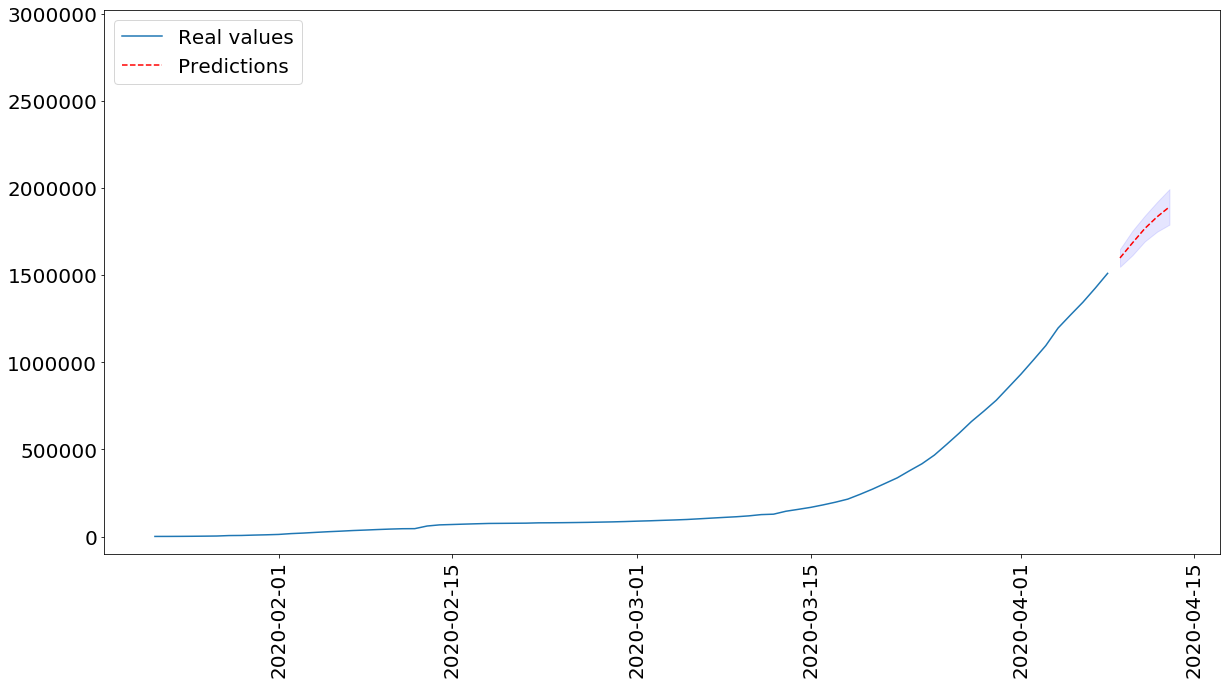

In [29]:
plt.figure(figsize=(20, 10))
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 
plt.plot(fullAvailableDateRange, originalData)
plt.plot(futureDateRange, recursivePredictions, linestyle='dashed', color='red')
lowerBound = recursivePredictions - recursiveError * recursivePredictions
upperBound = recursivePredictions + recursiveError * recursivePredictions
plt.fill_between(futureDateRange, lowerBound, upperBound, color='b', alpha=.1)
plt.legend(['Real values', 'Predictions'], prop={'size': 20}, loc=2)
plt.xticks( rotation=90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,maxValue*2))
plt.show()

In [30]:
print('Number of confirmed cases:')
for i, day in enumerate(futureDateRange):
    print(day.date(), ':', recursivePredictions[i], 'error:', int(round(recursiveError[i]*maxValue)))

Number of confirmed cases:
2020-04-09 : 1599620 error: 48205
2020-04-10 : 1685137 error: 63046
2020-04-11 : 1768087 error: 63109
2020-04-12 : 1835772 error: 70383
2020-04-13 : 1893026 error: 81477
